In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import matplotlib.patheffects as path_effects
import itertools
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway, normaltest
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
from itables import show
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.oneway import anova_oneway
import pingouin as pg
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors, origin_map
%load_ext autoreload
%autoreload 2

In [2]:
df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')
composite_meal = pd.read_csv('../data/composite_meals.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_16612\1328870569.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_16612\1328870569.py:2: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_16612\1328870569.py:3: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')


In [3]:
save_path = 'graphs'

# Food group hypothesis testing

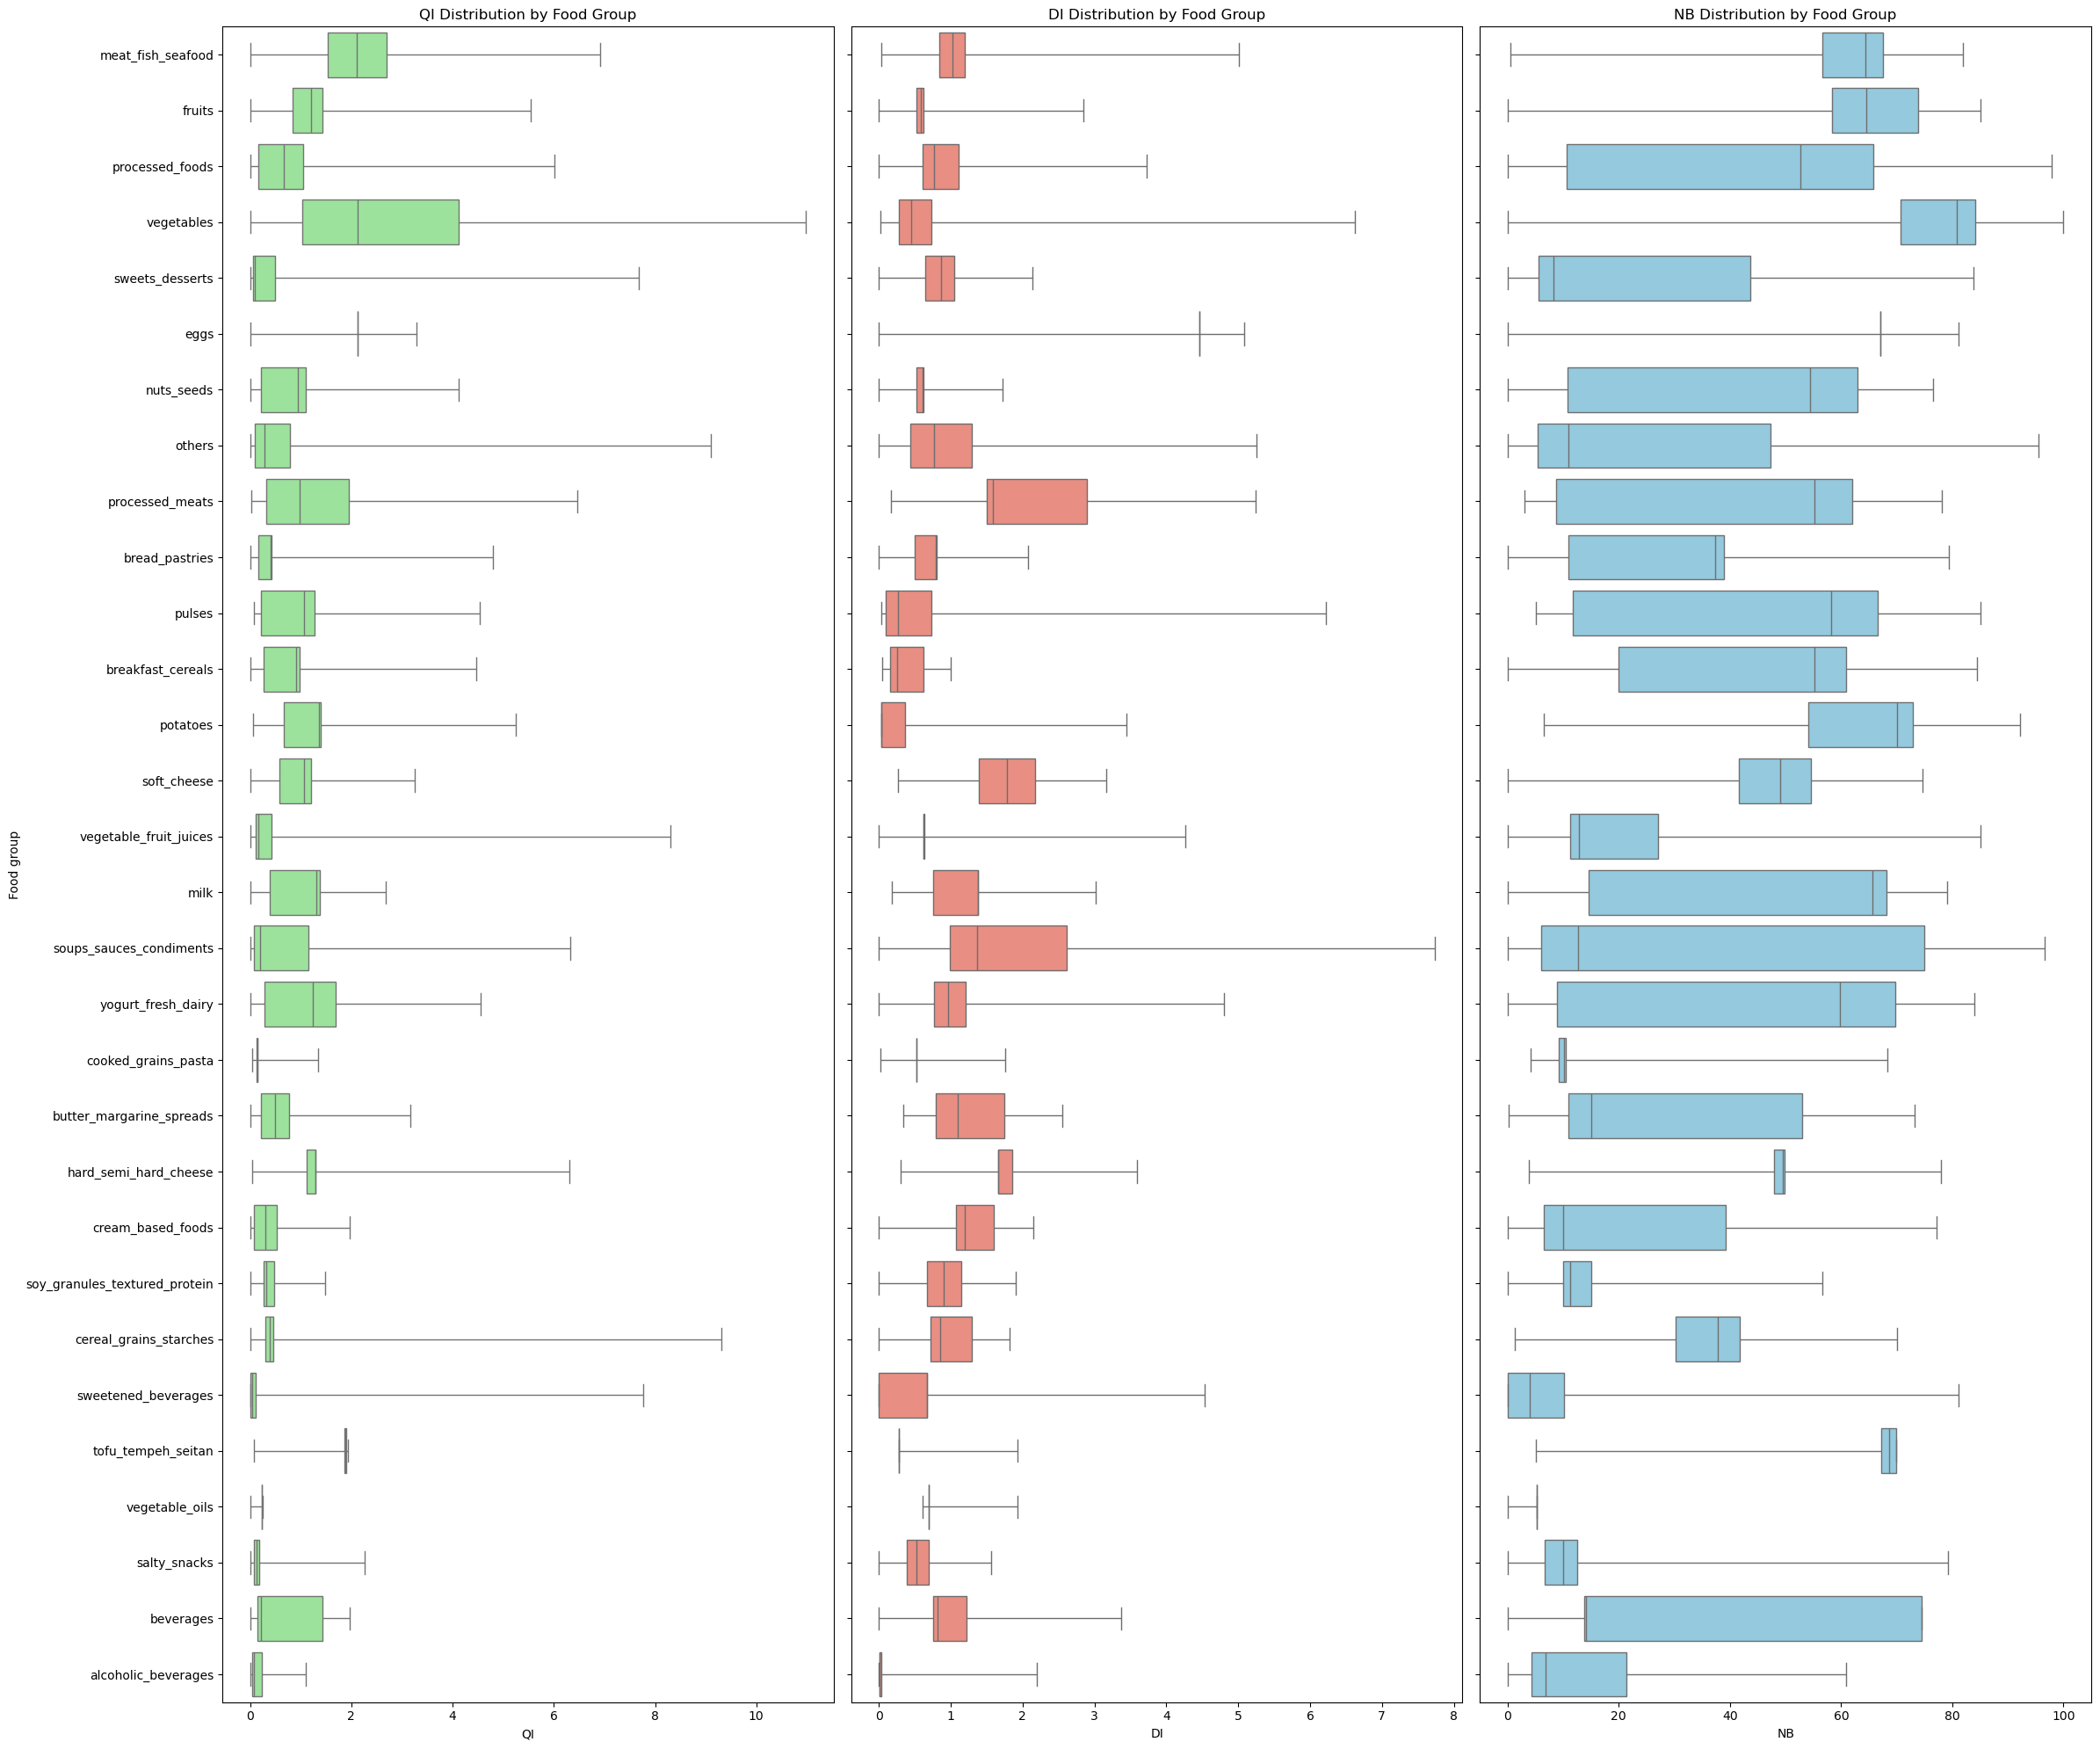

In [17]:
metrics = ['QI', 'DI', 'NB']
colors  = ['lightgreen', 'salmon', 'skyblue']

fig, axes = plt.subplots(ncols=3, figsize=(24, 20), sharey=True)

for ax, metric, c in zip(axes, metrics, colors):
    sns.boxplot(
        x=metric,
        y='food_group',
        data=df_food_clean_scaled,
        whis=(0, 100),
        color=c,
        ax=ax
    )
    ax.set_title(f'{metric} Distribution by Food Group')
    ax.set_xlabel(f'{metric}')
    if ax is not axes[0]:
        ax.set_ylabel('')     # only label y on the first plot
    else:
        ax.set_ylabel('Food group')

plt.tight_layout()
filename = f"{save_path}/generale_distribution_by_food_group.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## Non-parametric testing

- D'Agostino K2 test : = measure of departure from normality. Aim to gauge the compatibility of a given data with the null hypothesis that the data is a realization of independent, identically distributed Gaussian random variables
-

In [5]:
# Agostino K2 test
normaltest_results = []
for group, subdf in df_food_clean_scaled.groupby('food_group'):
    stat, p = stats.normaltest(subdf['DI'])
    normaltest_results.append({
        'food_group': group,
        'K2_stat':   stat,
        'p_value':   p
    })

normaltest_df = pd.DataFrame(normaltest_results).set_index('food_group').sort_values('p_value')

In [6]:
# Anderson-Darling A2 test
anderson_results = []
for group, subdf in df_food_clean_scaled.groupby('food_group'):
    res = stats.anderson(subdf['NB'], dist='norm')
    anderson_results.append({
        'food_group': group,
        'A2_stat':    res.statistic,
        'critical_5%':res.critical_values[2]  
    })

anderson_df = pd.DataFrame(anderson_results).set_index('food_group').sort_values('A2_stat', ascending=False)

**Observation** : QI, DI and NB distributions by food group are not normal. They are skewed, have long tails and contain extreme outliers, therefore they do not follow a symmetric bell shape.  
It is not possible to execute a parametric test (t-test or ANOVA) as the distribution is not normal

In [7]:
# Nutrient Balance NB
H_nb, p_nb, posthoc_nb = nonparametric_group_comparison(df_food_clean_scaled, 'NB')

# Quality Index QI
H_qi, p_qi, posthoc_qi = nonparametric_group_comparison(df_food_clean_scaled, 'QI')

# Disqualifying Index DI
H_di, p_di, posthoc_di = nonparametric_group_comparison(df_food_clean_scaled, 'DI')


Kruskal-Wallis H for NB = 59005.48, p = 0
Kruskal-Wallis H for QI = 74955.97, p = 0
Kruskal-Wallis H for DI = 85726.57, p = 0


Across QI, DI and NB, the non parametric Kruskal-Wallis test showed highly signigicant differences between food groups (p~0) and the majority of pairwise Mann-Whitney U comparison remain significant even after the Bonferroni correction. That mean that almost every food-group pair has a statistically distinct distribution for each metric. 

In [8]:
posthoc_nb[posthoc_nb['significant'] == False]

,group1,group2,U_stat,p_uncorrected,p_adjusted,significant
408,soy_granules_textured_protein,sweets_desserts,3667284.5,0.000136,0.059265,False
326,others,vegetable_fruit_juices,2480575.0,0.000181,0.078905,False
26,alcoholic_beverages,vegetable_oils,285045.0,0.000464,0.201906,False
58,bread_pastries,butter_margarine_spreads,3511164.0,0.000533,0.231803,False
171,cooked_grains_pasta,salty_snacks,540706.5,0.001271,0.553041,False
188,cream_based_foods,others,3205334.5,0.004021,1.000000,False
198,cream_based_foods,sweets_desserts,15629826.5,0.777820,1.000000,False
196,cream_based_foods,soy_granules_textured_protein,1003749.0,0.113069,1.000000,False
298,milk,yogurt_fresh_dairy,10041234.5,0.511447,1.000000,False
301,nuts_seeds,processed_foods,5789085.0,0.338492,1.000000,False


In [9]:
posthoc_qi[posthoc_qi['significant'] == False]

,group1,group2,U_stat,p_uncorrected,p_adjusted,significant
32,beverages,cereal_grains_starches,16633083.0,0.000229,0.099535,False
178,cooked_grains_pasta,vegetable_fruit_juices,812432.5,0.000406,0.176765,False
384,salty_snacks,sweets_desserts,7298549.0,0.000429,0.186785,False
39,beverages,milk,6902096.0,0.000605,0.262966,False
206,eggs,meat_fish_seafood,8821138.0,0.001471,0.640058,False
263,hard_semi_hard_cheese,yogurt_fresh_dairy,6214409.0,0.001743,0.758052,False
43,beverages,processed_foods,18148326.5,0.002128,0.925510,False
368,processed_meats,yogurt_fresh_dairy,6620085.0,0.273371,1.000000,False
200,cream_based_foods,vegetable_fruit_juices,3623006.0,0.068605,1.000000,False
151,cereal_grains_starches,soy_granules_textured_protein,3052902.5,0.114828,1.000000,False


In [10]:
posthoc_di[posthoc_di['significant'] == False]

,group1,group2,U_stat,p_uncorrected,p_adjusted,significant
383,salty_snacks,sweetened_beverages,3952202.5,0.000178,0.077531,False
415,sweetened_beverages,tofu_tempeh_seitan,3021437.0,0.000204,0.088666,False
416,sweetened_beverages,vegetable_fruit_juices,6956470.5,0.000207,0.090163,False
31,beverages,butter_margarine_spreads,473962.0,0.000278,0.120913,False
228,fruits,nuts_seeds,8305242.0,0.000498,0.216449,False
322,others,soy_granules_textured_protein,661423.0,0.000517,0.224951,False
56,beverages,yogurt_fresh_dairy,8812749.0,0.000739,0.321470,False
134,butter_margarine_spreads,yogurt_fresh_dairy,822474.0,0.001577,0.686169,False
254,hard_semi_hard_cheese,soft_cheese,3037033.0,0.179676,1.000000,False
327,others,vegetable_oils,51012.0,0.724380,1.000000,False


These non-significant paire are the instances where two food groups had statistically indistinguishable distributions after the Bonferroni correction. That means these pair of groups have the "same nutrients". In practical terms it is possible to swap one for another in a meal plan or reciple without materially changing the metric (e.g. hard_semi_har_cheese and soft_cheese, which is completely logical)

## Parametric testing

In [11]:

# 1. Transform NB (%) into proportions and logit
df_norm = df_food_clean_scaled.copy()
df_norm['NB_prop'] = df_norm['NB'] / 100
df_norm['NB_logit'] = np.log(df_norm['NB_prop'] / (1 - df_norm['NB_prop']))

# Drop infinities or NaNs from 0% or 100% cases
df_norm = df_norm.replace([np.inf, -np.inf], np.nan).dropna(subset=['NB_logit'])

# 2. Check normality of transformed NB_logit per group
print("\nD'Agostino's normality test on logit(NB) by group:")
normality = []
for name, sub in df_norm.groupby('food_group'):
    stat, p_val = normaltest(sub['NB_logit'])
    normality.append({'food_group': name, 'K2_stat': stat, 'p_value': p_val})
normality_df = pd.DataFrame(normality).set_index('food_group').sort_values('p_value')
display(normality_df)

# 3. One-way ANOVA on logit-transformed NB
groups_logit = [grp['NB_logit'].values for _, grp in df_norm.groupby('food_group')]
F, p_anova = f_oneway(*groups_logit)
print(f"\nANOVA F = {F:.2f}, p = {p_anova:.3g}")

c:\Users\Sophie\Anaconda\envs\Nutrient_Bachelor_Project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



D'Agostino's normality test on logit(NB) by group:


,K2_stat,p_value
food_group,,
alcoholic_beverages,1607.866357,0.000000e+00
beverages,16248.884860,0.000000e+00
bread_pastries,20316.498915,0.000000e+00
breakfast_cereals,44483.460347,0.000000e+00
cream_based_foods,4659.793839,0.000000e+00
hard_semi_hard_cheese,1714.612109,0.000000e+00
fruits,8816.035699,0.000000e+00
eggs,3933.741135,0.000000e+00
meat_fish_seafood,2373.386078,0.000000e+00



ANOVA F = 2543.63, p = 0


In [12]:
df2 = df_food_clean_scaled.copy()

# NB: logit transform (already between 0 and 1)
df2['NB_prop']  = df2['NB'] / 100
df2['NB_logit'] = np.log(df2['NB_prop'] / (1 - df2['NB_prop']))
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=['NB_logit'])

# QI: positive, so Box–Cox
# add tiny shift to avoid zeros
qi_shift = 1e-6
df2['QI_bc'], qi_lambda = boxcox(df2['QI'] + qi_shift)
print(f"QI Box–Cox λ = {qi_lambda:.3f}")

# DI: same approach
di_shift = 1e-6
df2['DI_bc'], di_lambda = boxcox(df2['DI'] + di_shift)
print(f"DI Box–Cox λ = {di_lambda:.3f}")

# ——————————————————————————————————————————————
# 2. ASSUMPTION CHECKS
# ——————————————————————————————————————————————
print("\nD’Agostino normality on residuals:")
for col in ['NB_logit','QI_bc','DI_bc']:
    k2, p = stats.normaltest(df2[col])
    print(f"  {col:10}  K2={k2:.1f}, p={p:.3g}")

print("\nLevene’s test for equal variances:")
for col in ['NB_logit','QI_bc','DI_bc']:
    stat, p = stats.levene(
        *[grp[col].values for _,grp in df2.groupby('food_group')]
    )
    print(f"  {col:10}  W={stat:.1f}, p={p:.3g}")

# ——————————————————————————————————————————————
# 3. WELCH ONE‐WAY ANOVA
# ——————————————————————————————————————————————
for col in ['NB_logit','QI_bc','DI_bc']:
    stat, p = anova_oneway(df2[col], df2['food_group'], use_var='unequal')
    print(f"Welch ANOVA for {col}:  F = {stat:.2f},  p = {p:.3g}")

c:\Users\Sophie\Anaconda\envs\Nutrient_Bachelor_Project\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


QI Box–Cox λ = 0.134
DI Box–Cox λ = 0.402

D’Agostino normality on residuals:
  NB_logit    K2=71180.6, p=0
  QI_bc       K2=5266.5, p=0
  DI_bc       K2=4040.1, p=0

Levene’s test for equal variances:
  NB_logit    W=814.5, p=0
  QI_bc       W=806.5, p=0
  DI_bc       W=745.4, p=0
Welch ANOVA for NB_logit:  F = 22264.33,  p = 0
Welch ANOVA for QI_bc:  F = 9055.99,  p = 0
Welch ANOVA for DI_bc:  F = 14907.84,  p = 0


# Global test across all food groups

In [13]:
# NB (non-parametric)
is_sig_nb, p_nb, test_nb, stat_nb = significance_test(
    df_food_clean_scaled,
    group_col     = "food_group",
    value_col     = "NB",
    non_parametric=True
)
print(f"{test_nb} on NB:  stat = {stat_nb:.2f},  p = {p_nb:.3g}")

# QI (non-parametric)
is_sig_qi, p_qi, test_qi, stat_qi = significance_test(
    df_food_clean_scaled,
    group_col     = "food_group",
    value_col     = "QI",
    non_parametric=True
)
print(f"{test_qi} on QI:  stat = {stat_qi:.2f},  p = {p_qi:.3g}")

# DI (non-parametric)
is_sig_di, p_di, test_di, stat_di = significance_test(
    df_food_clean_scaled,
    group_col     = "food_group",
    value_col     = "DI",
    non_parametric=True
)
print(f"{test_di} on DI:  stat = {stat_di:.2f},  p = {p_di:.3g}")

Kruskal-Wallis on NB:  stat = 59005.48,  p = 0
Kruskal-Wallis on QI:  stat = 74955.97,  p = 0
Kruskal-Wallis on DI:  stat = 85726.57,  p = 0


# Meal statistical analysis

In [14]:
# NB 
is_sig_nb, p_nb, test_nb, stat_nb = significance_test(
    composite_meal,
    group_col     = "meal",
    value_col     = "NB",
    non_parametric=True
)
print(f"{test_nb} for meals on NB:  stat = {stat_nb:.2f},  p = {p_nb:.3g}")

# QI 
is_sig_qi, p_qi, test_qi, stat_qi = significance_test(
    composite_meal,
    group_col     = "meal",
    value_col     = "QI",
    non_parametric=True
)
print(f"{test_qi} for meals on QI:  stat = {stat_qi:.2f},  p = {p_qi:.3g}")

# DI 
is_sig_di, p_di, test_di, stat_di = significance_test(
    composite_meal,
    group_col     = "meal",
    value_col     = "DI",
    non_parametric=True
)
print(f"{test_di} for meals on DI:  stat = {stat_di:.2f},  p = {p_di:.3g}")

Kruskal-Wallis for meals on NB:  stat = 122.01,  p = 2.85e-26
Kruskal-Wallis for meals on QI:  stat = 338.45,  p = 4.73e-73
Kruskal-Wallis for meals on DI:  stat = 594.35,  p = 1.7e-128


c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:2.964e-18 U_stat=4.399e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:2.267e-24 U_stat=4.078e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:3.514e-54 U_stat=3.257e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:2.742e-03 U_stat=3.245e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-10 U_stat=5.383e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:8.197e-47 U_stat=4.218e+07


c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:2.281e-09 U_stat=4.506e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:5.743e-41 U_stat=4.185e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.695e-118 U_stat=3.004e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:1.949e-17 U_stat=3.405e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:1.754e-26 U_stat=5.190e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:2.714e-60 U_stat=4.138e+07


c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.173e-02 U_stat=4.840e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:7.770e-06 U_stat=3.888e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.035e-26 U_stat=3.423e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:4.049e-10 U_stat=3.340e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:1.849e-13 U_stat=5.337e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.205e-05 U_stat=4.626e+07


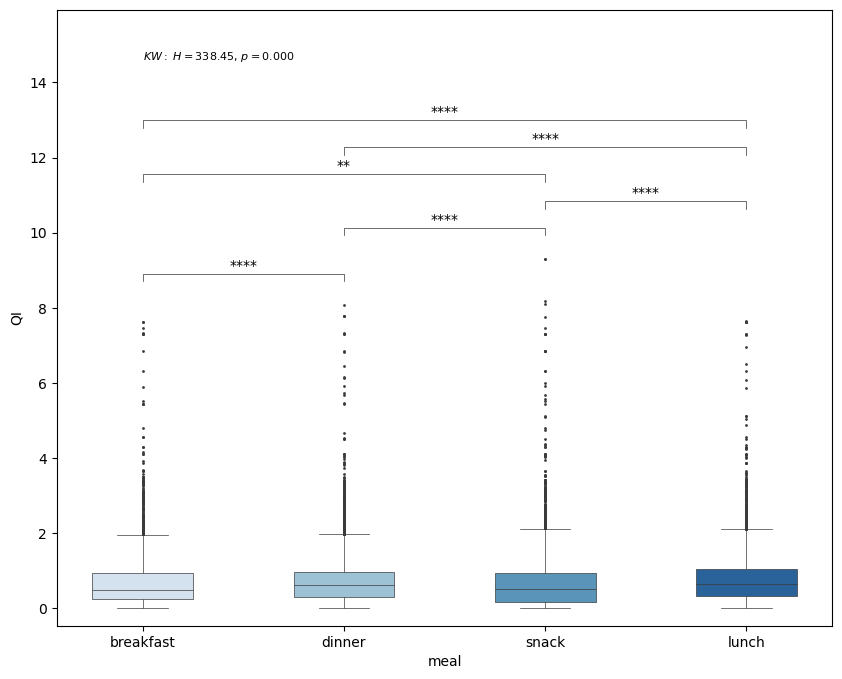

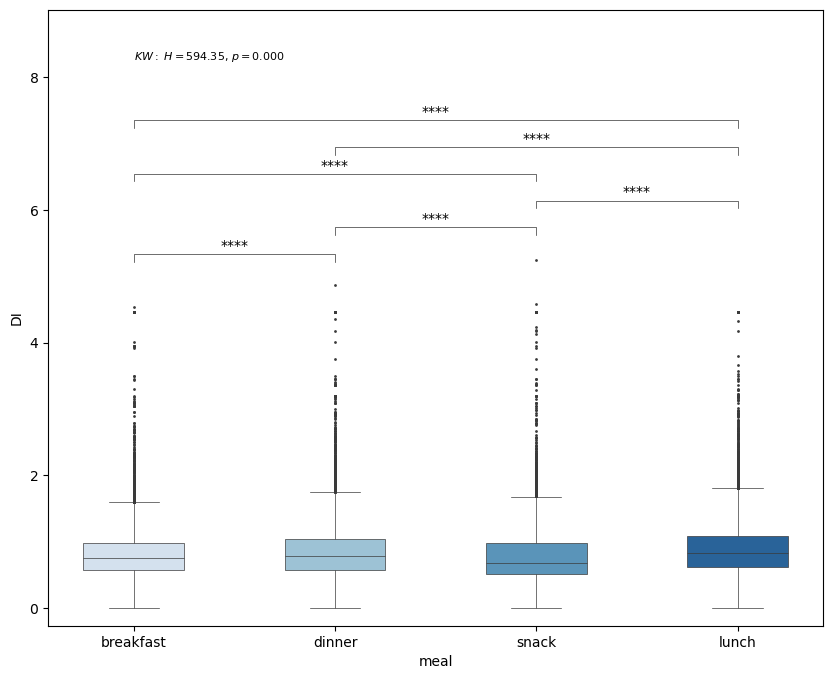

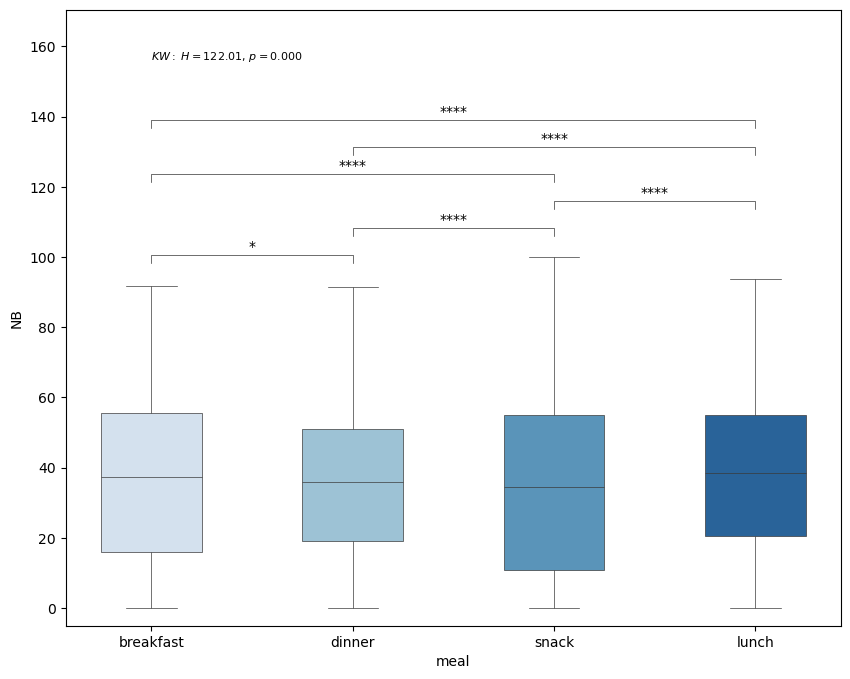

In [15]:
metric = ['QI', 'DI', 'NB']

for i in metric : 
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    test_quartile_differences(
        composite_meal, # your dataframe
        'meal', # grouping column (e.g good or bad food group)
        i, # target column e.g NB or QI or DI
        extremes=False,
        make_quartile=False,
        palette="Blues",
        verbose=False,
        ax=ax,
    )
    filename = f"{save_path}/{i}_by_meal_types.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:2.964e-18 U_stat=4.399e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:2.267e-24 U_stat=4.078e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:3.514e-54 U_stat=3.257e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:2.742e-03 U_stat=3.245e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-10 U_stat=5.383e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:8.197e-47 U_stat=4.218e+07


c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:2.281e-09 U_stat=4.506e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:5.743e-41 U_stat=4.185e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.695e-118 U_stat=3.004e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:1.949e-17 U_stat=3.405e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:1.754e-26 U_stat=5.190e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:2.714e-60 U_stat=4.138e+07


c:\Users\Sophie\Desktop\EPFL\Bachelor project\Bachelor-Project\analysis\../scripts\functions.py:963: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.173e-02 U_stat=4.840e+07
dinner vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:7.770e-06 U_stat=3.888e+07
snack vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.035e-26 U_stat=3.423e+07
breakfast vs. snack: Mann-Whitney-Wilcoxon test two-sided, P_val:4.049e-10 U_stat=3.340e+07
dinner vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:1.849e-13 U_stat=5.337e+07
breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.205e-05 U_stat=4.626e+07


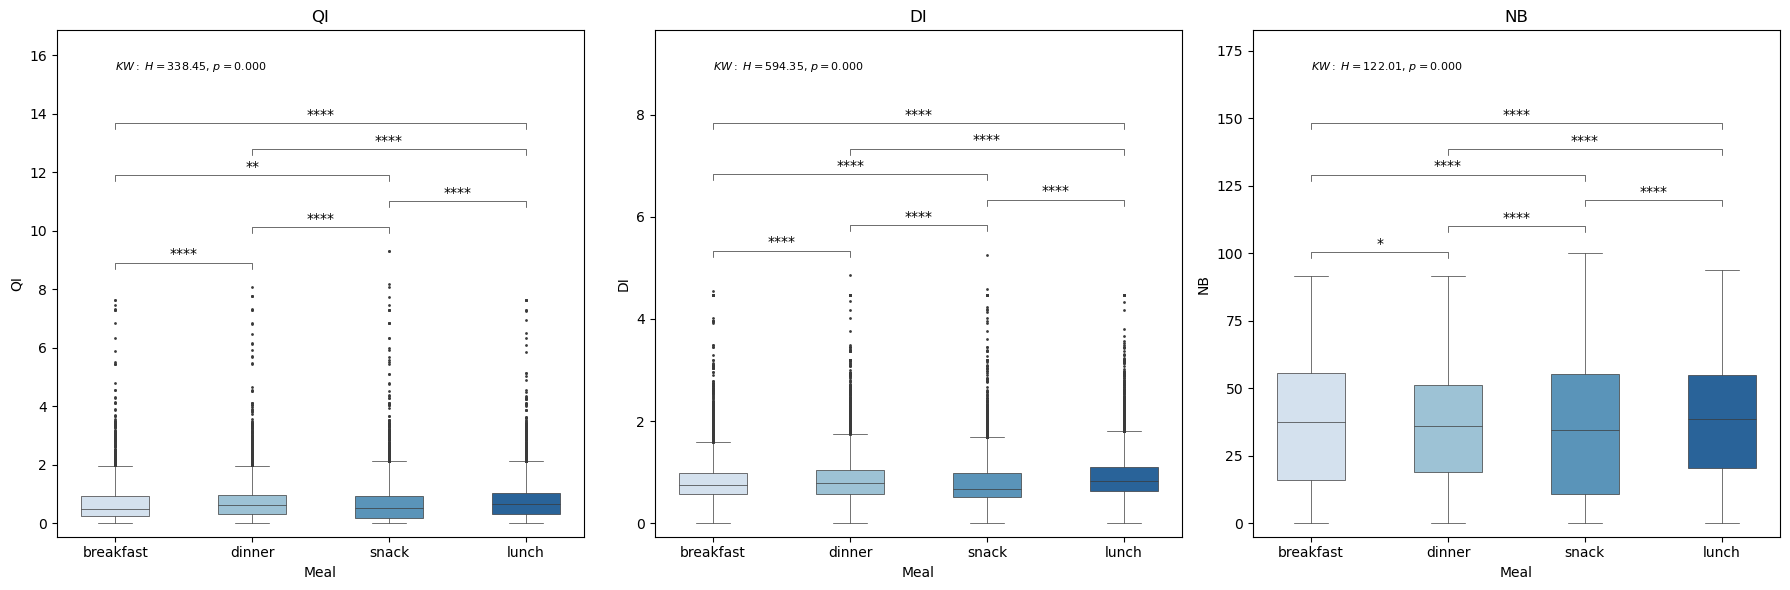

In [18]:
metrics = ['QI', 'DI', 'NB']
n = len(metrics)

# Create a single figure with n subplots in a row, sharing the x-axis (meal types)
fig, axes = plt.subplots(
    ncols=n,
    figsize=(6*n, 6),
    sharex=True
)

for ax, metric in zip(axes, metrics):
    test_quartile_differences(
        composite_meal,   # your dataframe
        'meal',           # grouping column
        metric,           # target column
        extremes=False,
        make_quartile=False,
        palette="Blues",
        verbose=False,
        ax=ax,
    )
    ax.set_title(metric)
    ax.set_xlabel('Meal')
    if ax is axes[0]:
        ax.set_ylabel(metric)  # only label the first subplot

plt.tight_layout()
filename = f"{save_path}/mann_whitney_wilcoxon_test_per_meal.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()